In [208]:
import numpy as np
import seaborn as sns
import matplotlib as mplt
import matplotlib.pyplot as plt
import glob
import scipy

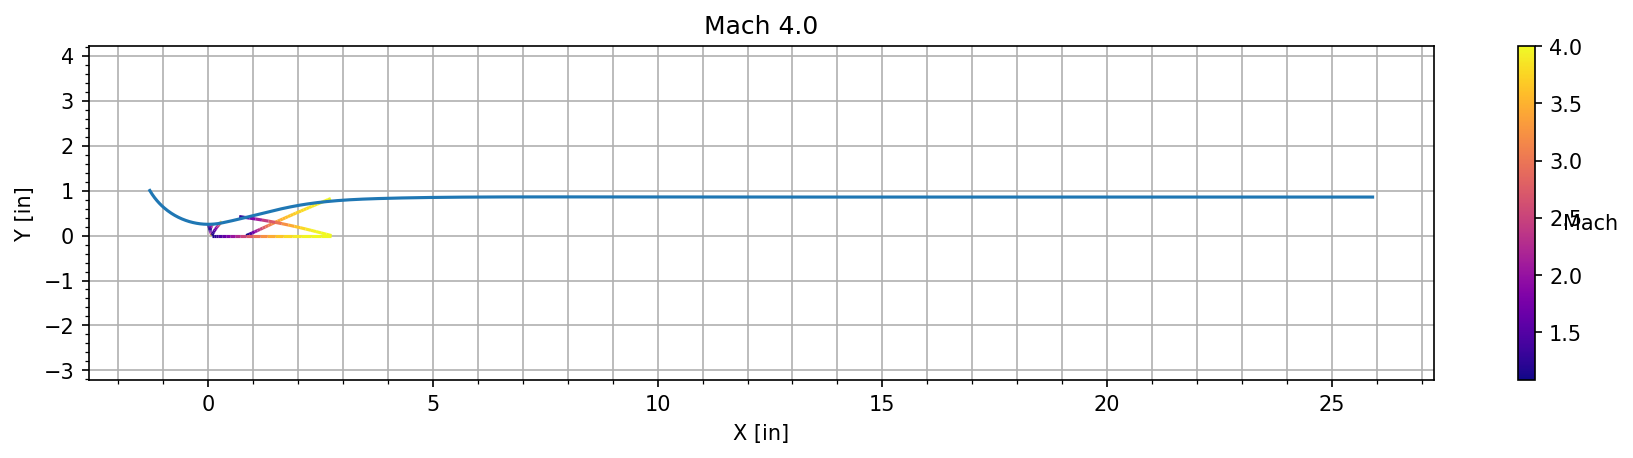

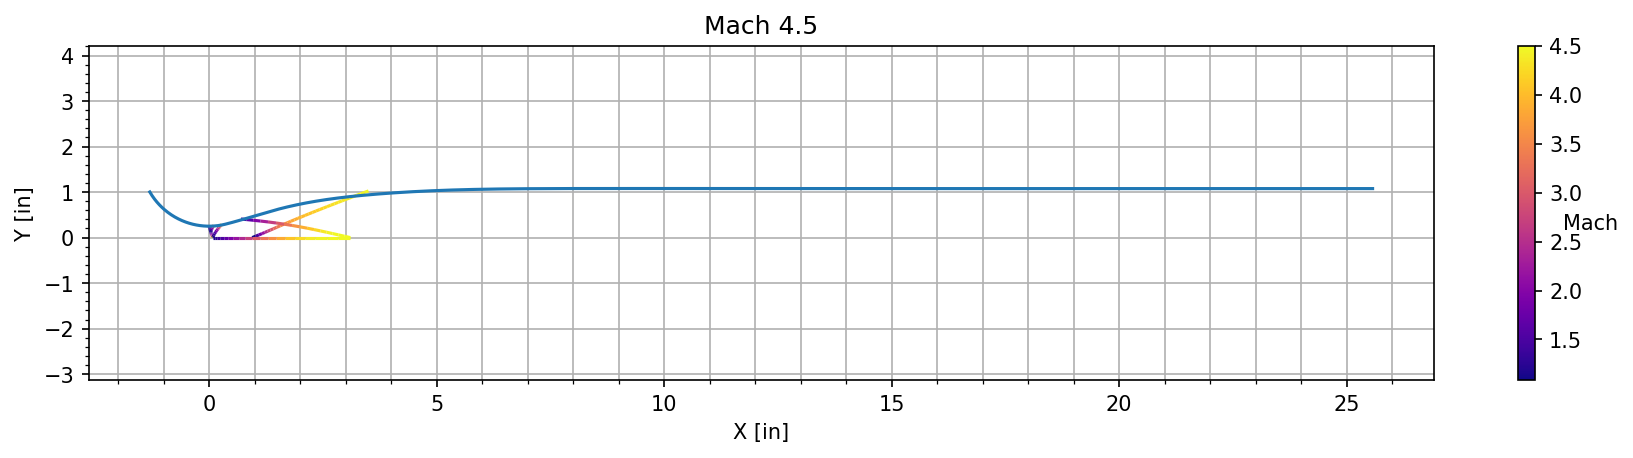

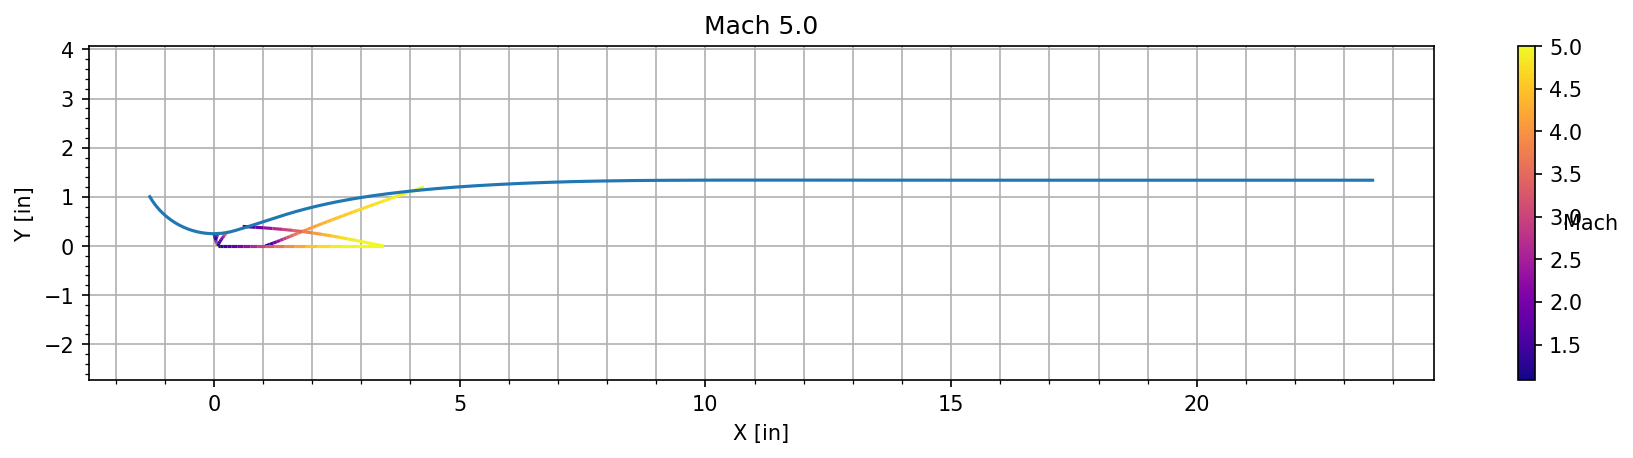

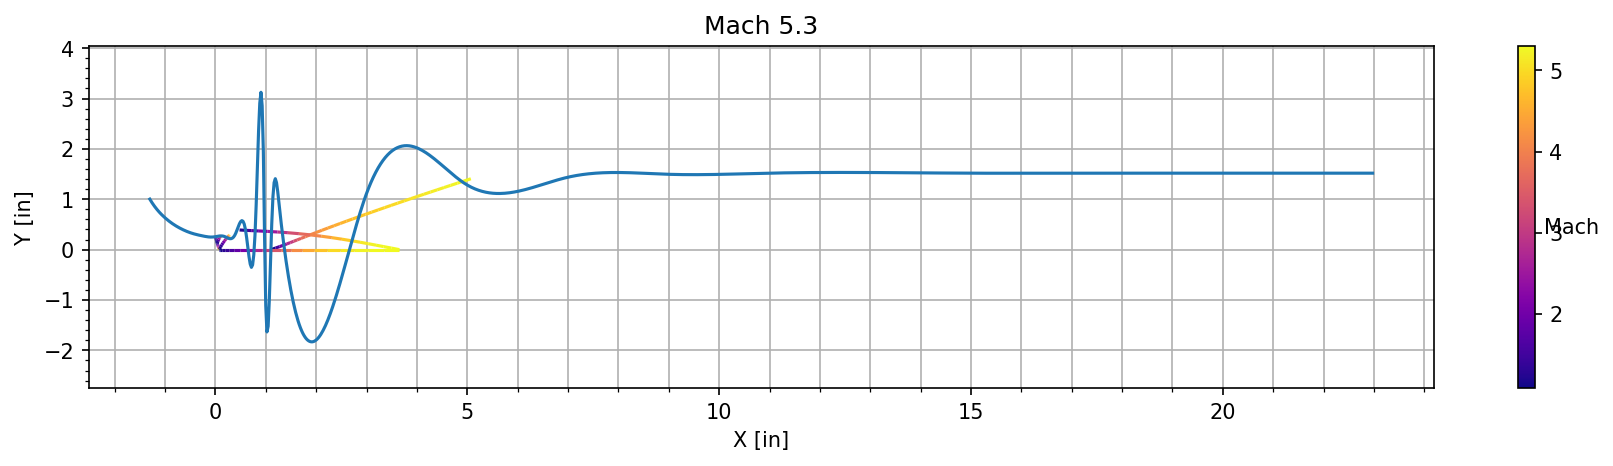

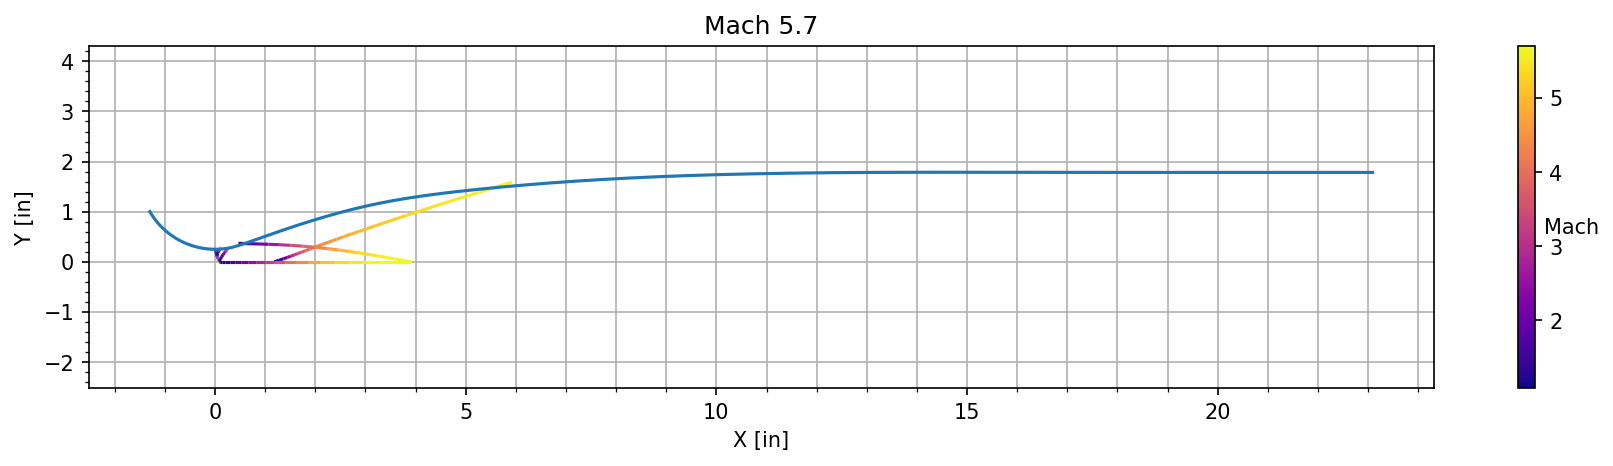

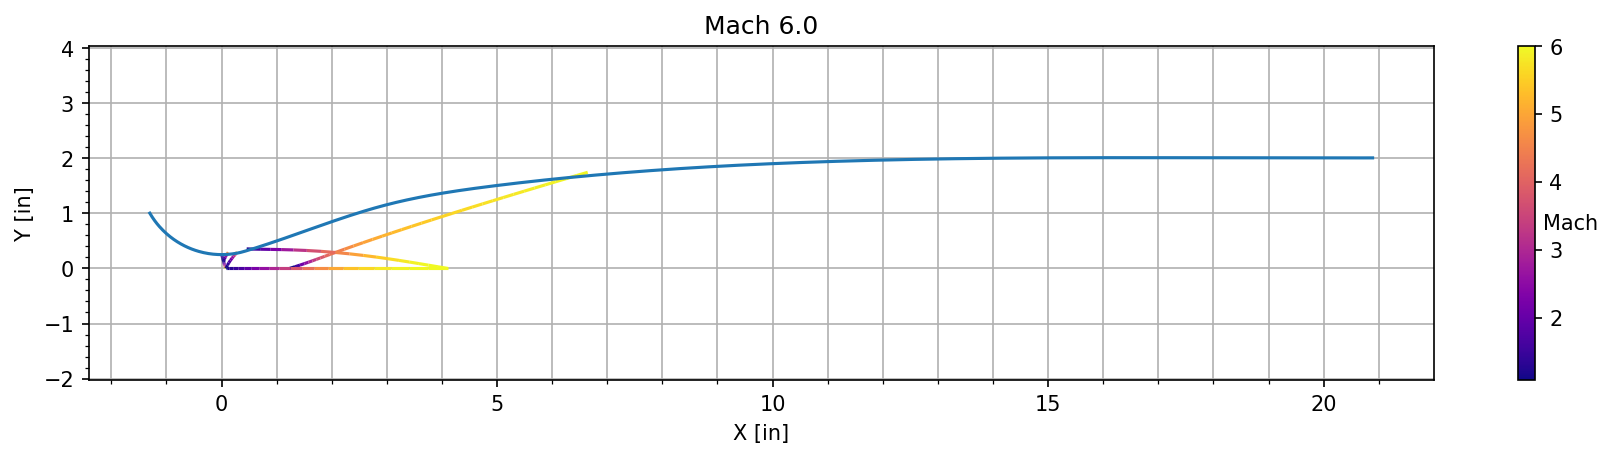

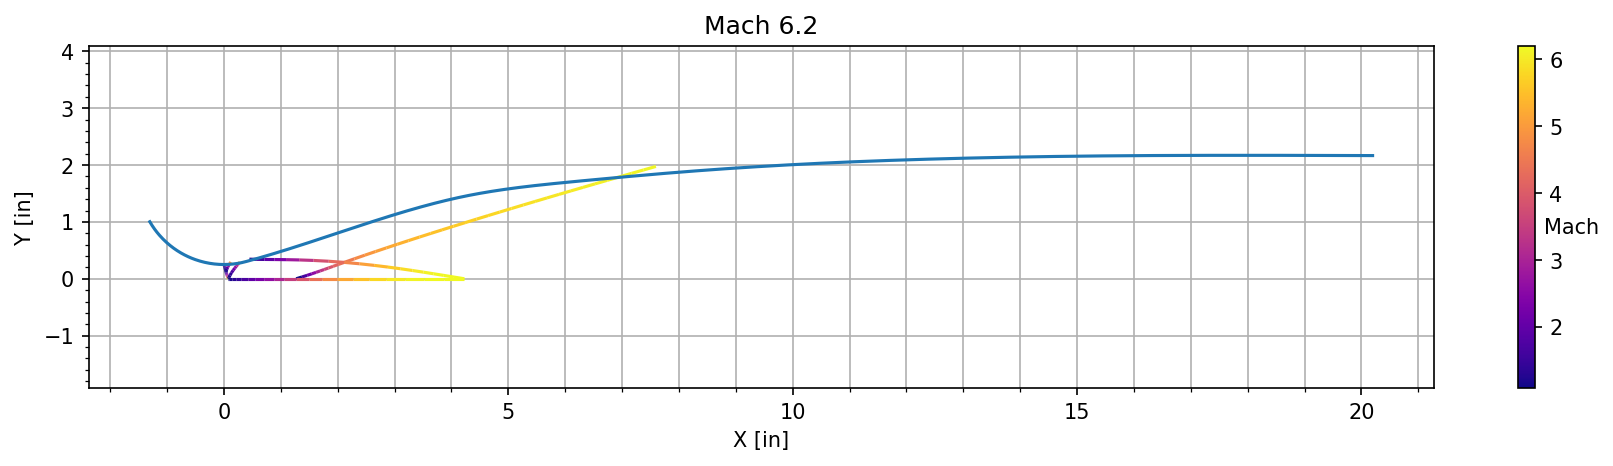

In [278]:
flist = glob.glob('complete/*txt')

for file in flist:

    with open(file, 'r') as in_file:
        source_file = in_file.readline().split(': ')[1]

    sw_name = file.split('\\')[1]
    coords = np.genfromtxt(f"SolidWorks/{sw_name}")[:, :2]

    with open(source_file.strip(), 'r') as in_file:
        source_text = in_file.readlines()

    delim = source_text[0].strip().split('  ')[0]
    heads = [[idx, line] for idx, line in enumerate(source_text) if delim in line]

    def get_head_idxs(head_part, heads):
        return [ar[0] for ar in heads if head_part in ar[1]]

    def get_array_from_txt(start_idx, source_text):
        continue_reading = True
        headers = []
        data = []

        cur_idx = start_idx
        while continue_reading:
            cur_idx += 1
            this_line = source_text[cur_idx]

            if this_line.strip() == '':
                continue

            if 'X(IN)' in this_line and len(headers) == 0:
                headers = [x.strip() for x in this_line.split('  ') if x != '']
                continue

            if (' X ' in this_line or 'X/YO' in this_line) and 'X(IN)' not in this_line and len(headers) == 0:
                data = []
                headers = None
                continue_reading = False
                continue

            invalid_chars = 'ABCDFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

            if any([bad_char in this_line for bad_char in invalid_chars]):
                if len(data) > 0:
                    continue_reading = False
                    continue
                else:
                    continue

            data.append(np.fromstring(this_line, sep=' '))

        return headers, np.vstack(data) if len(data) > 0 else None

    icontours = []
    for start in get_head_idxs('INVISCID CONTOUR', heads):
        icontours.append(get_array_from_txt(start, source_text))
    axial_ic = icontours[0][1]

    characteristics = []
    for start in get_head_idxs('CHARACTERISTIC', heads):
        characteristics.append(get_array_from_txt(start, source_text))

    def line_cmap(x, y, cv, cmap='plasma'):
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = mplt.collections.LineCollection(segments, cmap=cmap)
        lc.set_array(cv)
        return lc

    x_start = float([x for x in source_text[get_head_idxs('COORDINATES', heads)[0]+4].split(' ') if x.strip() != ''][0])
    x_end = float(source_text[get_head_idxs('COORDINATES', heads)[0]].split('LENGTH=')[1].strip())

    x = axial_ic[:, 2] - x_start
    y = np.zeros(axial_ic.shape[0])

    lc1 = line_cmap(x, y, axial_ic[:, 3])



    paper_ar = 2
    fig = plt.figure(figsize=(6*paper_ar, 1.5*paper_ar), dpi=150)
    ax = plt.gca()

    for charac in characteristics[1:]:
        lc = line_cmap(charac[1][:, 7] - x_start, charac[1][:, 8], charac[1][:, 3])
        ax.add_collection(lc)
    #     ax.plot(charac[1][:, 7] - x_start, charac[1][:, 8])

    ax.add_collection(lc1)
    ax.set_xlim([-1, x_end + 1])

    new_x = np.linspace(coords[:, 0].min(), coords[:, 0].max(), 2**10)
    interp_m = scipy.interpolate.interp1d(coords[:, 0], coords[:, 1], kind='cubic')

    ax.plot(new_x, interp_m(new_x))
    ax.minorticks_on()
    ax.grid(True, which='both', axis='x')
    ax.grid(True, which='major', axis='y')
    ax.set_xlabel('X [in]')
    ax.set_ylabel('Y [in]')
    ax.axis('equal')
    cbar = fig.colorbar(lc1)
    cbar.set_label('Mach', rotation=0)
    fig.tight_layout()
    mach_num = float(sw_name.split('_')[0].replace('M', ''))/10
    plt.title(f"Mach {mach_num}")
    fig.savefig(f'M{mach_num*10:.0f}.png')